# Setup

In [115]:
# Imports
import lightgbm as lgb
import os
import sklearn as skl
import numpy as np
import pandas as pd
import psutil
import pyspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
%matplotlib inline

os.environ["JAVA_HOME"] = r"C:\Program Files\Java\jdk-17"
os.environ["PYSPARK_PYTHON"] = r"C:\Users\rmcne\AppData\Local\Programs\Python\Python311\python.exe"

# I'm working across multiple devices. So, this code will always create a path to the folder containing the data.
data_folder_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "instacart-market-basket-analysis")
print(data_folder_path)

sc = pyspark.SparkContext()  # instantiate pyspark connection

spark = SparkSession.builder.appName("CSC84040_assignment1").getOrCreate()  # instantiate spark entry point

D:\School\2024 Fall\CSC84040\instacart-market-basket-analysis


ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at C:\Users\rmcne\AppData\Local\Temp\ipykernel_10328\1444969767.py:22 

# Part A: Exploratory Data Analysis
## 1. Perform Exploratory Data Analysis (EDA) and discuss the data and what you observe prior to beginning modeling and how the EDA insights impact how to proceed 

### Aisles

In [2]:
aisles = pd.read_csv(os.path.join(data_folder_path, "aisles.csv"))

In [3]:
print(f"No duplicate aisles: {len(pd.unique(aisles.aisle)) == len(aisles.aisle)}")

print(f"NA values: {aisles.isnull().sum().sum()}")

aisles.head()

No duplicate aisles: True
NA values: 0


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


Aisles appears to be a table of aisles (by name (str)) with unique id numbers assigned to each.

### Departments

In [4]:
departments = pd.read_csv(os.path.join(data_folder_path, "departments.csv"))

In [5]:
print(f"Unique departments {departments.__len__()}") # here len = nunique departments so long as duplicates == 0
print(f"No duplicate departments: {len(pd.unique(departments.department)) == len(departments.department)}")
print(f"NA values: {departments.isnull().sum().sum()}")

departments.head()

Unique departments 21
No duplicate departments: True
NA values: 0


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


Departments appears to be a table of departments (by name (str)) with unique id numbers assigned to each.

### Order_products__prior

In [177]:
order_products__prior = pd.read_csv(os.path.join(data_folder_path, "order_products__prior.csv"))
order_products__prior.__len__()

32434489

In [7]:
print(f"NA values: {order_products__prior.isnull().sum().sum()}")

print(f"Unique orders in dataset: {order_products__prior.order_id.nunique()}")

print(f"Frequency of reorder: {round(order_products__prior.reordered.mean(), 4) * 100}%")

order_products__prior.head()

NA values: 0
Unique orders in dataset: 3214874
Frequency of reorder: 58.97%


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


order_products__prior appears to be a table of products previously ordered by order (for ~3.4 million orders), including the order in which each product was added to cart & a binary flag for whether that product was previously ordered by that customer.

Median add_to_cart_order: 6.0


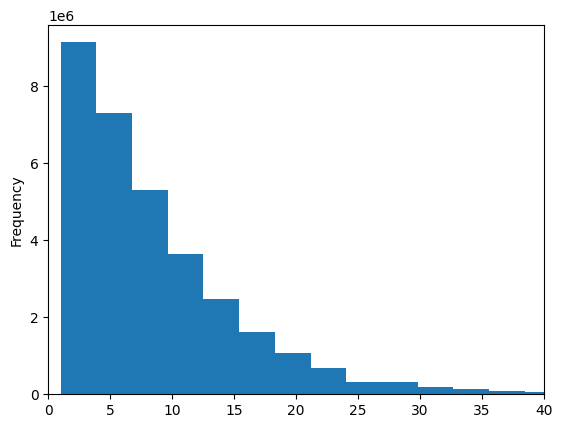

In [8]:
print(f"Median add_to_cart_order: {order_products__prior['add_to_cart_order'].median()}")
order_products__prior['add_to_cart_order'].plot.hist(bins=50)
plt.xlim(0, 40)
plt.show()

The max add_to_cart order is 145, but there are several outliers, so I clip my graph at 40 to see where most rows fall. The frequency of add_to_cart_order values seems to drop quickly. 
Given these outliers, I also look at the median instead of the mean. This shows that "most" items are added to an order in position 6 or less.

In [9]:
print(f"Median number of orders containing each product: {order_products__prior['product_id'].value_counts().median()}")
order_products__prior['product_id'].value_counts().sort_index()

Median number of orders containing each product: 60.0


product_id
1        1852
2          90
3         277
4         329
5          15
         ... 
49684       9
49685      49
49686     120
49687      13
49688      89
Name: count, Length: 49677, dtype: int64

Value counts of product_id shows that most products are represented in 60 or fewer orders, however a few products are extreme outliers. These may need to be dropped to produce a strong predictive model.

### Order_products__train

In [10]:
order_products__train = pd.read_csv(os.path.join(data_folder_path, "order_products__train.csv"))

In [11]:
print(f"NA values: {order_products__train.isnull().sum().sum()}")

print(f"Orders in dataset: {order_products__train.order_id.nunique()}")

print(f"Frequency of reorder: {round(order_products__train.reordered.mean(), 4) * 100}%")

print(f"Comparative size: {round((order_products__train.__len__() / order_products__prior.__len__()) * 100, 2)}%")

order_products__train.head()

NA values: 0
Orders in dataset: 131209
Frequency of reorder: 59.86%
Comparative size: 4.27%


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


order_products__train appears to be a training set of data of the same structure as order_produces_prior, but only contains 4.27% as much data. 

### Orders

In [68]:
orders = pd.read_csv(os.path.join(data_folder_path, "orders.csv"))

In [13]:
print(f"NA values: {orders.isnull().sum().sum()}")
print(f"Proportion of NAs {round(100 * orders.isnull().sum().sum()/orders.__len__(), 2)}%")
print(f"Orders in dataset: {orders.order_id.nunique()}")
print(f"Duplicate orders: {orders['order_id'].duplicated().sum()}")
orders[orders['days_since_prior_order'].isna()]

NA values: 206209
Proportion of NAs 6.03%
Orders in dataset: 3421083
Duplicate orders: 0


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
11,2168274,2,prior,1,2,11,NaN
26,1374495,3,prior,1,1,14,NaN
39,3343014,4,prior,1,6,11,NaN
45,2717275,5,prior,1,3,12,NaN
...,...,...,...,...,...,...,...
3420930,969311,206205,prior,1,4,12,NaN
3420934,3189322,206206,prior,1,3,18,NaN
3421002,2166133,206207,prior,1,6,19,NaN
3421019,2227043,206208,prior,1,1,15,NaN


In [14]:
orders[(orders['days_since_prior_order'].isna()) & (orders['eval_set'] != 'prior')].sum().sum()
# filter for days_since_prior_order is na & eval_set not 'prior'

np.float64(0.0)

All rows containing NAs are apparently part of the 'prior' set. No NAs (from this file, at least) in the train or test sets.

In [15]:
orders.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.214874e+06
mean,1.710542e+06,1.029782e+05,1.715486e+01,2.776219e+00,1.345202e+01,1.111484e+01
std,9.875817e+05,5.953372e+04,1.773316e+01,2.046829e+00,4.226088e+00,9.206737e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.552715e+05,5.139400e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.710542e+06,1.026890e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.565812e+06,1.543850e+05,2.300000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01


Orders contains items ordered categorized into the "prior" (previous orders), training & testing datasets, plus features for "order_number", day of the week when an order was placed, hour it was placed, and days since prior order. No duplicate order IDs, one row per order. Days since prior order contains about 6% NAs, presumably orders with no prior order. The maximum value for days_since_prior_order is 30. I'm curious why. Have values greater than 30 have been squished to 30? Have those rows been dropped? are those the NAs?

### Products

In [69]:
products = pd.read_csv(os.path.join(data_folder_path, "products.csv"))

In [17]:
print(f"NA values: {products.isnull().sum().sum()}")
print(f"Products in dataset: {products.product_id.nunique()}")
print(f"Duplicate products: {products['product_id'].duplicated().sum()}")
products.head()

NA values: 0
Products in dataset: 49688
Duplicate products: 0


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


Products contains information about each product, assigning a unique ID number to each product, along with the aisle & department where it can be located. There are just under 50,000 unique products in our data.

### Sample_submission

In [18]:
sample_submission = pd.read_csv(os.path.join(data_folder_path, "sample_submission.csv"))

In [19]:
sample_submission.head()

,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259


In [20]:
del(sample_submission)

This is a sample submission. For each order_id, there are space-separated pairs of previously ordered products (by product_id) most likely to be in a user's next order. For the original challenge, differs in format from what we will be creating.

### 2. Pre-processed data for use in the model and justify pre-processing methods. Note this may be different for each Part and/or algorithm you try. 

Impute NAs in days_since_prior_order by setting NA == 0. I'm assuming_days_since_prior_order is na implies it is a customer's first order, meaning 0 might be the most accurate, since there is no 'gap' since any prior order. 

In [91]:
orders['days_since_prior_order'].fillna(0, inplace=True)

C:\Users\rmcne\AppData\Local\Temp\ipykernel_10328\3779552717.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  orders['days_since_prior_order'].fillna(0, inplace=True)


Load order_products__prior as RDD

In [171]:
OPP_lines = sc.textFile(os.path.join(data_folder_path, 'order_products__prior.csv'))

OPP_baskets = OPP_lines.map(lambda l: l.split(','))

OPP_N = OPP_baskets.count()

print("N:", OPP_N)  # Length matches length when loaded with pd. Evidence that the data was loaded correctly.

OPP_header = OPP_baskets.first()  # Save header

OPP_baskets = OPP_baskets.filter(lambda row: row != OPP_header)  # Remove header row from rdd

OPP_baskets.take(5)

del(OPP_lines)

N: 32434490


Load products as RDD

In [22]:
products_lines = sc.textFile(os.path.join(data_folder_path, 'products.csv'))

products_baskets = products_lines.map(lambda l: l.split(',')).map(lambda row: (row[0], row[1]))

products_N = products_baskets.count()

print("N:", OPP_N)  # Length matches length when loaded with pd. Evidence that the data was loaded correctly.

products_header = products_baskets.first()  # Save header

products_baskets = products_baskets.filter(lambda row: row != products_header)  # Remove header row from rdd

products_baskets.take(5)

N: 32434490


[('1', 'Chocolate Sandwich Cookies'),
 ('2', 'All-Seasons Salt'),
 ('3', 'Robust Golden Unsweetened Oolong Tea'),
 ('4', 'Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce'),
 ('5', 'Green Chile Anytime Sauce')]

In [23]:
del(products_lines)

Create a dictionary of product_id to product_name for later use

In [24]:
product_id_to_name = dict(zip(products['product_id'], products['product_name']))
list(product_id_to_name.items())[:5]

[(1, 'Chocolate Sandwich Cookies'),
 (2, 'All-Seasons Salt'),
 (3, 'Robust Golden Unsweetened Oolong Tea'),
 (4, 'Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce'),
 (5, 'Green Chile Anytime Sauce')]

I get the impression from the instructions that identifying large lemon purchases might be a trick question. So I search for all items containing 'large lemon' rather than the singular item.

In [25]:
large_lemon_products = {product_id: name for product_id, name in product_id_to_name.items() if 'large lemon' in name.lower()}

# I also create lists here for easy filtering later.
large_lemon_ids = list(map(str, large_lemon_products.keys()))
large_lemon_names = list(large_lemon_products.values())

print(large_lemon_names)
print(large_lemon_ids)
large_lemon_products

['Bag of Large Lemons', 'Large Lemon']
['9434', '47626']


{9434: 'Bag of Large Lemons', 47626: 'Large Lemon'}

For all metrics, I will consider both of these items for 'large lemon purchases.'

# Part B: Association Rules
### Use “order_products__prior.csv” to build frequent itemsets and association rules to understand what products are often bought together. Also, use your findings to understand what drives market baskets and association rules that are indicative of large lemon purchases. Please provide commentary and rationale for everything you are doing.

First, calculate product frequencies. These are counts of the number of times an item occurs in the entire dataset. 

This will be necessary for calculating the support of each item set and association rules.

product_counts == singles_support from notes.


In [26]:
# Product counts
# Count 1 for each item occurrence
product_counts = OPP_baskets.map(lambda row: (row[1], 1))

# Sum total occurrences of each item
product_counts = product_counts.reduceByKey(lambda x, y: x + y)

# Filter out infrequent items
product_counts = product_counts.filter(lambda x: x[1] >= 100)

product_counts.take(5)

[('24838', 49569),
 ('38693', 4529),
 ('23423', 2415),
 ('26910', 463),
 ('9848', 101)]

For inspection and later transformations, collect product_counts into a dict.

In [27]:
# Collect
product_counts = dict(product_counts.collect())

# Sort descending by count
product_counts = dict(sorted(product_counts.items(), 
                             key=lambda item: item[1], 
                             reverse=True))

# Top 5 most frequently purchased items
list(product_counts.items())[:5]

[('24852', 472565),
 ('13176', 379450),
 ('21137', 264683),
 ('21903', 241921),
 ('47209', 213584)]

Let's take a look at what the top products are by name

In [28]:
# Get the top 10 most frequently purchased products by name
top_10_products = {product_id_to_name.get(int(product_id)): count 
                   for product_id, count in list(product_counts.items())[:10]}

# Output the result
top_10_products

{'Banana': 472565,
 'Bag of Organic Bananas': 379450,
 'Organic Strawberries': 264683,
 'Organic Baby Spinach': 241921,
 'Organic Hass Avocado': 213584,
 'Organic Avocado': 176815,
 'Large Lemon': 152657,
 'Strawberries': 142951,
 'Limes': 140627,
 'Organic Whole Milk': 137905}

In [29]:
del(top_10_products)

The most commonly purchased items appear to be among fresh fruit & vegetables, including large lemons.

I also get the counts of our large lemon products.

In [30]:
# Filter product_counts dictionary for these specific product_ids
total_lemon_counts = {key: product_counts[key] for key in large_lemon_ids}

total_lemon_counts

{'9434': 2678, '47626': 152657}

The vast majority of large lemon purchases appear to be of large lemons ('47626'). Only about 2% (2678 orders) of large lemon product orders are *bags* of large lemons.

In [31]:
# Sum counts
total_lemon_count = sum(total_lemon_counts.values())

print(total_lemon_count)

155335


155,335 orders containing large lemon products.

Next, calculate product pair frequencies. This will be used for calculating association rules.

In [32]:
# Product pair counts
# Create (order_id, product_id) tuples
orders_to_products = OPP_baskets.map(lambda row: (row[0], row[1]))

# Group by order_id
order_product_baskets = orders_to_products.groupByKey().map(lambda x: list(set(x[1])))  

def generate_pairs(basket):  # Generates product pairs
    pairs = []
    n = len(basket)
    # For each product in the basket, pair with every product that comes after it (avoids duplicate pairs)
    for i in range(n):
        for j in range(i + 1, n):
            pairs.append((basket[i], basket[j]))
    return pairs

# Generate all pairs for each basket
product_pairs = order_product_baskets.flatMap(generate_pairs)

# Count the occurrences of each pair
pair_counts = product_pairs.map(lambda pair: (pair, 1))

# Sum total occurrences of each pair
pair_counts = pair_counts.reduceByKey(lambda x, y: x + y)

# Filter out infrequent pairs
pair_counts = pair_counts.filter(lambda x: x[1] >= 100)

pair_counts.take(5)

[(('47766', '43394'), 344),
 (('28849', '37766'), 167),
 (('28849', '10017'), 351),
 (('7751', '5212'), 105),
 (('10749', '44632'), 1569)]

In [33]:
del(orders_to_products)

In [34]:
# Convert the product_ids to names for inspection

pair_counts_names = [
    (
        (product_id_to_name.get(int(pair_count[0][0]), pair_count[0][0]),  # Get name for first product_id
         product_id_to_name.get(int(pair_count[0][1]), pair_count[0][1])),  # Get name for second product_id
        pair_count[1]  # Keep count value 
    )
    for pair_count in pair_counts.collect()
]

pair_counts_names

[(('Organic Avocado', 'Organic Lactose Free Whole Milk'), 344),
 (('No Salt Added Black Beans', 'XL Emerald White Seedless Grapes'), 167),
 (('No Salt Added Black Beans', 'Tilapia Filet'), 351),
 (('Tomato Ketchup', 'Watermelon Chunks'), 105),
 (('Organic Red Bell Pepper', 'Sparkling Water Grapefruit'), 1569),
 (('Honey Greek Yogurt', 'Organic Large Brown Grade AA Cage Free Eggs'), 175),
 (('Honey Yoghurt', 'Raspberry Yoghurt'), 1313),
 (('Cucumber Kirby', 'Organic Bell Pepper'), 570),
 (('Organic Red Onion', 'Gluten Free Omega Flax & Fiber Bread'), 116),
 (('Organic Cilantro', 'Organic Whole String Cheese'), 1771),
 (('Organic Cilantro', 'Boneless Skinless Chicken Breast'), 843),
 (('Organic Cilantro', 'Mild Salsa'), 656),
 (('Organic Large Extra Fancy Fuji Apple', 'Bag of Organic Bananas'), 22978),
 (('Organic Large Extra Fancy Fuji Apple',
   'EnviroKidz Gluten Free & Wheat Free Gorilla Munch Corn Puff Cereal'),
  179),
 (('Lactose Free Low Fat Vanilla Yogurt', 'Bag of Organic Banan

In [35]:
del(pair_counts_names)

Next, lets look at only pairs containing large_lemon products

In [36]:
# Filter pair_counts for pairs where either product is a large lemon product
lemon_pair_counts = pair_counts.filter(lambda pair_count: pair_count[0][0] in large_lemon_ids or pair_count[0][1] in large_lemon_ids)

# Sort by count
lemon_pair_counts = lemon_pair_counts.sortBy(lambda x: x[1], ascending=False)

lemon_pair_counts.take(5)

[(('47626', '24852'), 40775),
 (('47626', '21903'), 22413),
 (('47626', '24964'), 15307),
 (('47626', '21137'), 15110),
 (('47209', '47626'), 14851)]

Let's inspect these by name.

In [37]:
# Convert the product_ids to names for inspection

top_lemon_pair_names = [
    (
        (product_id_to_name.get(int(pair_count[0][0]), pair_count[0][0]),  # Get name for first product_id
         product_id_to_name.get(int(pair_count[0][1]), pair_count[0][1])),  # Get name for second product_id
        pair_count[1]  # Keep count value 
    )
    for pair_count in lemon_pair_counts.top(10, key=lambda x: x[1])  # Top 10 large lemon pairs
]

top_lemon_pair_names

[(('Large Lemon', 'Banana'), 40775),
 (('Large Lemon', 'Organic Baby Spinach'), 22413),
 (('Large Lemon', 'Organic Garlic'), 15307),
 (('Large Lemon', 'Organic Strawberries'), 15110),
 (('Organic Hass Avocado', 'Large Lemon'), 14851),
 (('Limes', 'Large Lemon'), 13952),
 (('Large Lemon', 'Limes'), 13451),
 (('Organic Avocado', 'Large Lemon'), 13099),
 (('Large Lemon', 'Organic Avocado'), 11318),
 (('Large Lemon', 'Organic Zucchini'), 10875)]

In [38]:
del(lemon_pair_counts)

It looks like large lemons are often bought alongside other frequently purchased items, this may be less informative than looking at pairs where the other item is less commonly purchased. For instance, there may not be much predictive information in the fact that large lemons and bananas (both among the top 10 most commonly purchased items individually) are very often purchased together.

pair_counts == doubles_support form notes.

For inspection, transform the RDD to have three elements: item_1, item_2, count

In [39]:
# # Widen to 3-tuple
# pair_counts_wide = pair_counts.map(lambda x: (x[0][0], x[0][1], x[1]))
# 
# # Make item_1 key for the purpose of joining
# pair_counts_wide_names = pair_counts_wide.map(lambda x: (x[0], (x[1], x[2])))
# # Results in shape (item_1, (item_2, count))
# 
# # Join to get product_name for item_1
# pair_counts_wide_names = pair_counts_wide_names.join(products_baskets)
# # Results in shape (item_1, ((item_2, count), product_name_1))
# 
# # Map result to get the product_name for item_1
# pair_counts_wide_names = pair_counts_wide_names.map(lambda x: (x[1][0][0], (x[1][1], x[1][0][1])))
# # Results in shape (item_2, (product_name_1, count))
# 
# # Join for item_2
# pair_counts_wide_names = pair_counts_wide_names.join(products_baskets)
# # Results in shape (item_2, (product_name_1, count), product_name_2)
# 
# # Map result to get the product_name for item_2
# pair_counts_wide_names = pair_counts_wide_names.map(lambda x: (x[1][0][0], x[1][1], x[1][0][1]))
# # Results in shape (product_name_1, product_name_2, count)
# 
# # Collect as pandas df
# pair_counts_wide_names_df = spark.createDataFrame(pair_counts_wide_names, schema=["product_name_1", "product_name_2", "count"]).toPandas()
# 
# # Sort descending by count
# pair_counts_wide_names_df.sort_values(by='count', ascending=False, inplace=True)
# 
# # Top 10 pairs
# pair_counts_wide_names_df[:10]

In [40]:
del(products_baskets)

The above code produces a neat df of pairs with both the actual name of each item and counts of each pair. 

Unfortunately, I had written the above on a more powerful workstation and didn't realize this cell would overburden the small laptop where I'm now working. Don't attempt to run the above unless you have something like a recent i9 and 16+GB RAM.

Lastly, I use the confidence_doubles_helper function to produce association rules

In [41]:
def confidence_doubles_helper(double_support):
    double, support = double_support
    support = float(support)
    u, v = double
    uv_conf = support / product_counts[u]
    vu_conf = support / product_counts[v]
    return (('%s -> %s' % (u, v), uv_conf),
            ('%s -> %s' % (v, u), vu_conf))

doubles_conf = pair_counts.flatMap(confidence_doubles_helper)
doubles_conf.take(5)

[('47766 -> 43394', 0.0019455362949975963),
 ('43394 -> 47766', 0.040580394007313905),
 ('28849 -> 37766', 0.005980518550350953),
 ('37766 -> 28849', 0.010609911054637865),
 ('28849 -> 10017', 0.012569832402234637)]

We now have our association rules for each item in our dataset. But I would also like to look at only association rules where either item is among large lemon products.

In [42]:
# Filter doubles_conf to include only pairs where either product is in large_lemon_ids
lemon_doubles_conf = doubles_conf.filter(lambda x: any(id in x[0] 
                                                          for id in large_lemon_ids))

# Take the top 5 results
lemon_doubles_conf.take(5)

[('47626 -> 30918', 0.0010350000327531655),
 ('30918 -> 47626', 0.1070460704607046),
 ('43768 -> 47626', 0.07982726184368052),
 ('47626 -> 43768', 0.01223003203259595),
 ('47626 -> 34745', 0.0007991772404802925)]

For use in my predictive modeling, I produce an RDD of association rules for when large_lemon_products are the second item.

In [43]:
# Function to check if the second item is a large lemon product
def second_item_is_large_lemon(rule):
    # Split by ' -> ' to get the two product_ids
    second_product_id = rule.split(' -> ')[1]
    # Check if second is in large_lemon_ids
    return second_product_id in large_lemon_ids

# Function to get first product_id
def first_product_in_pair(rule):
    # Split the rule string by ' -> ' and return only the first product ID
    return rule.split(' -> ')[0]

# Filter doubles_conf and update the tuple to contain only the first product ID
lemon_first_doubles_conf = doubles_conf.filter(
    lambda x: second_item_is_large_lemon(x[0])  # Filter by second item being a large lemon product
).map(lambda x: (first_product_in_pair(x[0]), x[1]))  # Extract first product ID and keep the confidence score

# Take the top 5 results
lemon_first_doubles_conf.take(5)

[('30918', 0.1070460704607046),
 ('43768', 0.07982726184368052),
 ('34745', 0.04386911183027688),
 ('4799', 0.09913378248315688),
 ('47766', 0.06401040635692673)]

In [44]:
del(doubles_conf)

I kept using IDs and converting to names only when I wanted to inspect because I was under the impression that shorter strings might mean more efficient processing, but I've now gotten into a situation where I want to inspect something that will require replacing substrings with some regex. The following took a bit of trial and error. I'm curious what the tradeoff in execution time would have been had I just replaced all product_ids with product_name at the beginning and forged forward with those values instead of having to convert incessantly.

In [45]:
# Replace product_ids with product_names

lemon_doubles_conf_names = [
    (
        ('%s -> %s' % (  # Replace ' -> ' string after operation
            product_id_to_name.get(int(rule.split(' -> ')[0])),  # First product (split on ' -> ' and look up name by id)
            product_id_to_name.get(int(rule.split(' -> ')[1]))   # Second product (split on ' -> ' and look up name by id)
        )),
        confidence  # Keep confidence val
    )
    for rule, confidence in lemon_doubles_conf.collect()
]

# Sort
lemon_doubles_conf_names.sort(key=lambda x: x[1], reverse=True)

# Output the result
lemon_doubles_conf_names[:10]

[('Flat Fillet Anchovies in Olive Oil with Salt Added -> Large Lemon',
  0.2910569105691057),
 ('Large Lemon -> Banana', 0.26710206541462234),
 ('Unsalted Vegetable Cooking Stock -> Large Lemon', 0.26405867970660146),
 ('Capers -> Large Lemon', 0.2490272373540856),
 ('Chick Peas Reduced Sodium Garbanzos -> Large Lemon', 0.24109014675052412),
 ('Organic Bagged Carrots -> Large Lemon', 0.23135333741579914),
 ('4% Milkfat Cottage Cheese Small Curd 22 OZ -> Large Lemon',
  0.22141560798548093),
 ('Original Cooking Chicken Stock -> Large Lemon', 0.22122762148337596),
 ('Wild Caught Anchovy Paste -> Large Lemon', 0.21904761904761905),
 ('Sweet Grape Tomatoes -> Large Lemon', 0.2178714859437751)]

In [46]:
del(lemon_doubles_conf_names, lemon_doubles_conf)

The strongest association rules suggest that customers:
Frequently buy large lemon products when they are also buying anchovy products, vegetables, capers, chick peas, cottage cheese, chicken stock, and grape tomatoes.
When buying large lemon products, frequently buy bananas.

#  Part C: Predictive Modeling
### Using “order_products__prior.csv” to train a model and “order_products__train.csv” ONLY for scoring, train a model to predict if large lemons (hint: careful here) will be in an order (for all orders in “order_products__train.csv”) given the other items in the order and any other information in the other datasets provided. Please provide commentary and rationale for everything you are doing.

Now, I want to aggregate down to one row per order, but that will require deciding how to widen product_id. My first thoughts are to either one-hot encode and have a column for every possible product as is done in the workbook (~50,000 columns * every additional column for each product), or to have a column for each subsequent item in an order (e.g. product_1, product_2, ... product_n), but that will potentially introduce ordinality where we don't necessarily want it. My workaround is to use the additional data to produce a df where the other products in an order contribute their confidence score towards lemons. 

I could also produce a single column from all the product_ids that is the cumulative sum confidence score based on all the other items in an order that the next item will be a large lemon product based on the other items in an order (along with a binary feature for whether the user associated with an order has ordered lemons before, a single feature for whether the order contains any reorders/how many, etc.), but this could muddle the add_to_cart_order, which would determine whether lemon product comes before or after, meaning a different confidence score. extra processing to determine whether a product is being added to cart before or after lemons (two different confidence scores). 

I'm not sure if this is violating the directions, but at this point, I've written & deleted most of the code for all 3 of these approaches and it's probably safe to say I'm overthinking this.

First I merge in our additional data. I'm assuming it's ok to start working with pandas dfs here, since that is what is done in the workbooks.

In [178]:
# del(order_products__prior_for_model)

In [179]:
# Merge order data
order_products__prior_for_model = order_products__prior.merge(orders, 
                                                    on="order_id", 
                                                    how='left')

# Merge product data
order_products__prior_for_model = order_products__prior_for_model.merge(products, 
                                                    on="product_id", 
                                                    how='left')

# Drop product_name because it is colinear with product_id
order_products__prior_for_model.drop("product_name", 
                           axis=1, 
                           inplace=True)

order_products__prior_for_model.drop("eval_set",
                                     axis=1,
                                     inplace=True)

order_products__prior_for_model.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id
0,2,33120,1,1,202279,3,5,9,8.0,86,16
1,2,28985,2,1,202279,3,5,9,8.0,83,4
2,2,9327,3,0,202279,3,5,9,8.0,104,13
3,2,45918,4,1,202279,3,5,9,8.0,19,13
4,2,30035,5,0,202279,3,5,9,8.0,17,13


Now, I take it we want to predict whether a large lemon product will be added to an order based on what has already been added to the cart. So, I need to drop from my training data all rows for products that were added to an order *after* a large_lemon product. This will also help circumvent the problem of determining direction in the training data, which does not contain rows for large lemon products. Another option would be to take the average confidence score per pair between both directions, but I'm afraid that will lose more information than this method.

In [180]:
large_lemon_ids_int = [9434,47626]

# Create mask for large lemon products
is_large_lemon = order_products__prior_for_model['product_id'].isin(large_lemon_ids_int)

# Find the min add_to_cart_order of large lemon products within each order
large_lemon_orders = order_products__prior_for_model[is_large_lemon].groupby('order_id')['add_to_cart_order'].min().reset_index()
large_lemon_orders.columns = ['order_id', 'large_lemon_add_to_cart_order']

# Merge large lemon add_to_cart_order back to the original DataFrame
order_products_with_lemon_order = order_products__prior_for_model.merge(large_lemon_orders, 
                                                                        on='order_id', 
                                                                        how='left')

# Drop rows where add_to_cart_order is greater than the large lemon add_to_cart_order
# also ake sure large_lemon_add_to_cart_order is not null
order_products__prior_for_model = order_products_with_lemon_order[
    (order_products_with_lemon_order['add_to_cart_order'] <= order_products_with_lemon_order['large_lemon_add_to_cart_order']) |
    (order_products_with_lemon_order['large_lemon_add_to_cart_order'].isnull())
    ]

# Drop extra large_lemon_add_to_cart_order col
order_products__prior_for_model.drop('large_lemon_add_to_cart_order', 
                                     axis=1, 
                                     inplace=True)

order_products__prior_for_model.head()

C:\Users\rmcne\AppData\Local\Temp\ipykernel_10328\850312629.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_products__prior_for_model.drop('large_lemon_add_to_cart_order',


,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id
0,2,33120,1,1,202279,3,5,9,8.0,86,16
1,2,28985,2,1,202279,3,5,9,8.0,83,4
2,2,9327,3,0,202279,3,5,9,8.0,104,13
3,2,45918,4,1,202279,3,5,9,8.0,19,13
4,2,30035,5,0,202279,3,5,9,8.0,17,13


In [181]:
del(is_large_lemon, order_products_with_lemon_order)

Create a single variable that is the cumulative confidence score for large lemon product as the second item based on all other products in each order.

In [182]:
# Convert to dict for lookup
lemon_first_conf_dict = dict(lemon_first_doubles_conf.collect())

# Make keys int to match product_id dtype
lemon_first_conf_dict = {int(k): v for k, v in lemon_first_conf_dict.items()}

# New column 'product_confidence' by mapping the product_id to its confidence score
order_products__prior_for_model['product_confidence'] = order_products__prior_for_model['product_id'].map(lemon_first_conf_dict)

# Fill NaN values with 0, assuming products not in the lemon_conf_dict have a confidence score of 0
order_products__prior_for_model['product_confidence'].fillna(0, 
                                                             inplace=True)
# Group by order_id and sum product_confidence scores
order_confidence_sum = order_products__prior_for_model.groupby('order_id')['product_confidence'].sum().reset_index()

# Rename the column to indicate it's the sum of confidence scores for the order
order_confidence_sum.columns = ['order_id', 'order_confidence_sum']

# Merge the sum of confidence scores back into the original DataFrame
order_products__prior_for_model = order_products__prior_for_model.merge(order_confidence_sum, 
                                                                        on='order_id', 
                                                                        how='left')

# drop unnecessary column 
order_products__prior_for_model.drop(['product_confidence'], axis=1, inplace=True)

order_products__prior_for_model.head()

C:\Users\rmcne\AppData\Local\Temp\ipykernel_10328\3691997836.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  order_products__prior_for_model['product_confidence'].fillna(0,


,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id,order_confidence_sum
0,2,33120,1,1,202279,3,5,9,8.0,86,16,0.358018
1,2,28985,2,1,202279,3,5,9,8.0,83,4,0.358018
2,2,9327,3,0,202279,3,5,9,8.0,104,13,0.358018
3,2,45918,4,1,202279,3,5,9,8.0,19,13,0.358018
4,2,30035,5,0,202279,3,5,9,8.0,17,13,0.358018


For aggregating, reduce aisle_id to a single binary of whether the order contains any items that were in the isle_id == 24 (same as lemons) or 34 (same as bag of large lemons) and department_id == 4 (same as lemons) or 1 (same as bag of large lemons). Note: errors are for deprecation in "in_place", we can ignore them for now. Here I use numpy, because trying to use pandas results in a RAM error.

In [183]:
# # Create a new column to mark if aisle_id is 24 or 34
# order_products__prior_for_model['aisle_24_or_34_bin'] = np.where(
#     (order_products__prior_for_model['aisle_id'] == 23) |
#     (order_products__prior_for_model['aisle_id'] == 34), 
#     1, 
#     0)
# 
# # Group by order_id and sum the new department_4_or_1 column
# aisle_24_or_34_count = order_products__prior_for_model.groupby('order_id')['aisle_24_or_34_bin'].sum().reset_index()
# 
# order_products__prior_for_model.drop('aisle_24_or_34_bin', 
#                                      axis=1, 
#                                      inplace=True)
# 
# # Merge the counts back into our df
# order_products__prior_for_model = order_products__prior_for_model.merge(aisle_24_or_34_count,
#                                                                         on='order_id',
#                                                                         how='left')        

In [184]:
# del(aisle_24_or_34_count)

In [185]:
# # Create a new column to mark if department_id is 4 or 1
# order_products__prior_for_model['department_4_or_1_bin'] = np.where(
#     (order_products__prior_for_model['department_id'] == 4) |
#     (order_products__prior_for_model['department_id'] == 1), 
#     1, 
#     0)
# 
# # Group by order_id and sum the new department_4_or_1 column
# department_4_or_1_count = order_products__prior_for_model.groupby('order_id')['department_4_or_1_bin'].sum().reset_index()
# 
# order_products__prior_for_model.drop('department_4_or_1_bin',
#                                      axis=1,
#                                      inplace=True)
# 
# order_products__prior_for_model = order_products__prior_for_model.merge(department_4_or_1_count, 
#                                                                         on='order_id', 
#                                                                         how='left')

In [186]:
# del(department_4_or_1_count)

In [187]:
# # Fill NaN values with 0
# order_products__prior_for_model['aisle_24_or_34_count'].fillna(0, 
#                                                                inplace=True)
# order_products__prior_for_model['department_4_or_1_count'].fillna(0, 
#                                                                   inplace=True)
# 
# order_products__prior_for_model.head()

The code to produce aisle and department value counts is too RAM intensive for my current computer, so I have to leave this out.

Now drop redundant cols for aisle and department.

In [188]:
order_products__prior_for_model.drop(['aisle_id', 'department_id'], axis=1, inplace=True)

Create our target variable.

In [189]:
large_lemon_ids_int = [9434,47626]

# All orders that contain large lemons
orders_with_large_lemons = order_products__prior_for_model[order_products__prior_for_model['product_id'].isin(large_lemon_ids_int)]['order_id'].unique()

# Set contains_large_lemons to 1 for all rows in those orders
order_products__prior_for_model['contains_large_lemons'] = np.where(
    order_products__prior_for_model['order_id'].isin(orders_with_large_lemons), 
    1, 
    0)

del(orders_with_large_lemons)

order_products__prior_for_model.describe()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_confidence_sum,contains_large_lemons
count,3.120484e+07,3.120484e+07,3.120484e+07,3.120484e+07,3.120484e+07,3.120484e+07,3.120484e+07,3.120484e+07,3.120484e+07,3.120484e+07,3.120484e+07
mean,1.710742e+06,2.556159e+04,8.099525e+00,5.919045e-01,1.029293e+05,1.713266e+01,2.741753e+00,1.342911e+01,1.034954e+01,5.771439e-01,3.924850e-02
std,9.873749e+05,1.409851e+04,6.943753e+00,4.914810e-01,5.946386e+04,1.755936e+01,2.086647e+00,4.247628e+00,8.906498e+00,4.420874e-01,1.941856e-01
min,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.558460e+05,1.351200e+04,3.000000e+00,0.000000e+00,5.140900e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00,2.451463e-01,0.000000e+00
50%,1.710965e+06,2.519900e+04,6.000000e+00,1.000000e+00,1.026010e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00,4.805447e-01,0.000000e+00
75%,2.565560e+06,3.789500e+04,1.100000e+01,1.000000e+00,1.543820e+05,2.400000e+01,5.000000e+00,1.600000e+01,1.400000e+01,8.066612e-01,0.000000e+00
max,3.421083e+06,4.968800e+04,1.450000e+02,1.000000e+00,2.062090e+05,9.900000e+01,6.000000e+00,2.300000e+01,3.000000e+01,6.483905e+00,1.000000e+00


Drop all rows containing large lemon products for training

In [190]:
order_products__prior_for_model = order_products__prior_for_model[~order_products__prior_for_model['product_id'].isin(large_lemon_ids_int)]

Finally, aggregate by order_id

In [191]:
# Aggregate by order_id
order_products__prior_agg = order_products__prior_for_model.groupby('order_id').agg({
    'product_id': 'count',  # Count the total number of products in the order
    'user_id': 'max',  # I take max arbitrarily because all vals should be the same
    'order_number': 'max',  # as above
    'order_dow': 'max',  # as above
    'order_hour_of_day': 'max',  # as above
    'days_since_prior_order': 'max',  # as above
    'order_confidence_sum': 'max',  # as above
    'contains_large_lemons': 'max', # as above
}).reset_index()


In [192]:
# Quick check if I aggregated correctly
order_products__prior_agg['order_id'].nunique() == len(order_products__prior_agg)

True

In [193]:
order_products__prior_agg.describe()

,order_id,product_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_confidence_sum,contains_large_lemons
count,3.201950e+06,3.201950e+06,3.201950e+06,3.201950e+06,3.201950e+06,3.201950e+06,3.201950e+06,3.201950e+06,3.201950e+06
mean,1.710834e+06,9.697060e+00,1.029699e+05,1.719332e+01,2.776823e+00,1.344341e+01,1.001703e+01,3.598106e-01,4.447633e-02
std,9.875429e+05,7.305752e+00,5.953329e+04,1.780125e+01,2.041538e+00,4.226821e+00,9.048511e+00,3.471581e-01,2.061509e-01
min,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.556602e+05,4.000000e+00,5.138500e+04,5.000000e+00,1.000000e+00,1.000000e+01,3.000000e+00,1.015288e-01,0.000000e+00
50%,1.711104e+06,8.000000e+00,1.026640e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00,2.615481e-01,0.000000e+00
75%,2.566062e+06,1.300000e+01,1.543720e+05,2.400000e+01,5.000000e+00,1.600000e+01,1.400000e+01,5.139836e-01,0.000000e+00
max,3.421083e+06,1.450000e+02,2.062090e+05,9.900000e+01,6.000000e+00,2.300000e+01,3.000000e+01,6.483905e+00,1.000000e+00


Some garbage collection before I move forward.

In [194]:
del(order_products__prior, order_products__prior_for_model, order_product_baskets, OPP_baskets, OPP_header, product_pairs, product_counts, aisles, order_confidence_sum, large_lemon_orders, large_lemon_names, product_pairs, pair_counts, top_lemon_pair_names, lemon_first_doubles_conf)

NameError: name 'order_product_baskets' is not defined

I then split my X from my target vector.

In [195]:
y_train = order_products__prior_agg['contains_large_lemons']
X_train = order_products__prior_agg.drop("contains_large_lemons", axis=1)

I instantiate & train my model.

In [196]:
class_ratio = len(y_train[y_train==0]) / len(y_train[y_train==1])

lgb_model = lgb.LGBMClassifier(scale_pos_weight = class_ratio,
                               random_state= 42, 
                               n_estimators=1000, 
                               learning_rate=0.1,   
                               max_depth=8,   
                               n_jobs=-1)

# Fit the model
lgb_model.fit(X_train, y_train,
              eval_set=[(X_train, y_train)],
              eval_metric='logloss')

[LightGBM] [Info] Number of positive: 142411, number of negative: 3059539
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 3201950, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.044476 -> initscore=-3.067302
[LightGBM] [Info] Start training from score -3.067302


LGBMClassifier(max_depth=8, n_estimators=1000, n_jobs=-1, random_state=42,
               scale_pos_weight=21.48386711700641)

Finally, I fit and measure performance.

# TESTING

Apply the necessary preprocessing to the training data. First merging:

In [197]:
# Merge order data
order_products__train_processed = order_products__train.merge(orders,
                                                              on="order_id",
                                                              how='left')

# Merge product data
order_products__train_processed = order_products__train_processed.merge(products,
                                                                        on="product_id",
                                                                        how='left')

# Drop product_name because it is colinear with product_id
order_products__train_processed.drop("product_name",
                                     axis=1,
                                     inplace=True)

order_products__train_processed.drop("eval_set",
                                     axis=1,
                                     inplace=True)

order_products__train_processed.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id
0,1,49302,1,1,112108,4,4,10,9.0,120,16
1,1,11109,2,1,112108,4,4,10,9.0,108,16
2,1,10246,3,0,112108,4,4,10,9.0,83,4
3,1,49683,4,0,112108,4,4,10,9.0,83,4
4,1,43633,5,1,112108,4,4,10,9.0,95,15


Then handling of target var.

In [198]:
# Create mask for large lemon products
is_large_lemon = order_products__train_processed['product_id'].isin(large_lemon_ids_int)

# Find the min add_to_cart_order of large lemon products within each order
large_lemon_orders = order_products__train_processed[is_large_lemon].groupby('order_id')['add_to_cart_order'].min().reset_index()
large_lemon_orders.columns = ['order_id', 'large_lemon_add_to_cart_order']

# Merge large lemon add_to_cart_order back to the original DataFrame
order_products_with_lemon_order = order_products__train_processed.merge(large_lemon_orders,
                                                                        on='order_id',
                                                                        how='left')

# Drop rows where add_to_cart_order is greater than the large lemon add_to_cart_order
# also ake sure large_lemon_add_to_cart_order is not null
order_products__train_processed = order_products_with_lemon_order[
    (order_products_with_lemon_order['add_to_cart_order'] <= order_products_with_lemon_order['large_lemon_add_to_cart_order']) |
    (order_products_with_lemon_order['large_lemon_add_to_cart_order'].isnull())
    ]

# Drop extra large_lemon_add_to_cart_order col
order_products__train_processed.drop('large_lemon_add_to_cart_order',
                                     axis=1,
                                     inplace=True)

order_products__train_processed.head()

C:\Users\rmcne\AppData\Local\Temp\ipykernel_10328\2108267737.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_products__train_processed.drop('large_lemon_add_to_cart_order',


,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id
0,1,49302,1,1,112108,4,4,10,9.0,120,16
1,1,11109,2,1,112108,4,4,10,9.0,108,16
2,1,10246,3,0,112108,4,4,10,9.0,83,4
3,1,49683,4,0,112108,4,4,10,9.0,83,4
4,1,43633,5,1,112108,4,4,10,9.0,95,15


Then confidence scores

In [199]:
# New column 'product_confidence' by mapping the product_id to its confidence score
order_products__train_processed['product_confidence'] = order_products__train_processed['product_id'].map(lemon_first_conf_dict)

# Fill NaN values with 0, assuming products not in the lemon_conf_dict have a confidence score of 0
order_products__train_processed['product_confidence'].fillna(0,
                                                             inplace=True)
# Group by order_id and sum product_confidence scores
order_confidence_sum = order_products__train_processed.groupby('order_id')['product_confidence'].sum().reset_index()

# Rename the column to indicate it's the sum of confidence scores for the order
order_confidence_sum.columns = ['order_id', 'order_confidence_sum']

# Merge the sum of confidence scores back into the original DataFrame
order_products__train_processed = order_products__train_processed.merge(order_confidence_sum,
                                                                        on='order_id',
                                                                        how='left')

# drop unnecessary column 
order_products__train_processed.drop(['product_confidence'], axis=1, inplace=True)

order_products__train_processed.head()

C:\Users\rmcne\AppData\Local\Temp\ipykernel_10328\971177540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_products__train_processed['product_confidence'] = order_products__train_processed['product_id'].map(lemon_first_conf_dict)
C:\Users\rmcne\AppData\Local\Temp\ipykernel_10328\971177540.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) inste

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id,order_confidence_sum
0,1,49302,1,1,112108,4,4,10,9.0,120,16,0.256503
1,1,11109,2,1,112108,4,4,10,9.0,108,16,0.256503
2,1,10246,3,0,112108,4,4,10,9.0,83,4,0.256503
3,1,49683,4,0,112108,4,4,10,9.0,83,4,0.256503
4,1,43633,5,1,112108,4,4,10,9.0,95,15,0.256503


Drop cols.

In [200]:
order_products__train_processed.drop(['aisle_id', 'department_id'], axis=1, inplace=True)

Create our target var

In [201]:
# All orders that contain large lemons
orders_with_large_lemons = order_products__train_processed[order_products__train_processed['product_id'].isin(large_lemon_ids_int)]['order_id'].unique()

# Set contains_large_lemons to 1 for all rows in those orders
order_products__train_processed['contains_large_lemons'] = np.where(
    order_products__train_processed['order_id'].isin(orders_with_large_lemons),
    1,
    0)

del(orders_with_large_lemons)

order_products__train_processed.describe()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_confidence_sum,contains_large_lemons
count,1.314127e+06,1.314127e+06,1.314127e+06,1.314127e+06,1.314127e+06,1.314127e+06,1.314127e+06,1.314127e+06,1.314127e+06,1.314127e+06,1.314127e+06
mean,1.706816e+06,2.553952e+04,8.413456e+00,6.022911e-01,1.030773e+05,1.712583e+01,2.705717e+00,1.358514e+01,1.702237e+01,5.879066e-01,5.054458e-02
std,9.895819e+05,1.412776e+04,7.182421e+00,4.894249e-01,5.948342e+04,1.670132e+01,2.163289e+00,4.236681e+00,1.043723e+01,4.524369e-01,2.190659e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.446480e+05,1.330400e+04,3.000000e+00,0.000000e+00,5.168500e+04,6.000000e+00,1.000000e+00,1.100000e+01,7.000000e+00,2.438099e-01,0.000000e+00
50%,1.703570e+06,2.521100e+04,6.000000e+00,1.000000e+00,1.028510e+05,1.100000e+01,3.000000e+00,1.400000e+01,1.500000e+01,4.888003e-01,0.000000e+00
75%,2.567327e+06,3.792300e+04,1.200000e+01,1.000000e+00,1.549440e+05,2.100000e+01,5.000000e+00,1.700000e+01,3.000000e+01,8.298339e-01,0.000000e+00
max,3.421070e+06,4.968800e+04,8.000000e+01,1.000000e+00,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01,3.726424e+00,1.000000e+00


Drop rows containing lemons for testing

In [202]:
order_products__train_processed = order_products__train_processed[~order_products__train_processed['product_id'].isin(large_lemon_ids_int)]


Aggregate

In [203]:
# Aggregate by order_id
order_products__train_agg = order_products__train_processed.groupby('order_id').agg({
    'product_id': 'count',  # Count the total number of products in the order
    'user_id': 'max',  # I take max arbitrarily because all vals should be the same
    'order_number': 'max',  # as above
    'order_dow': 'max',  # as above
    'order_hour_of_day': 'max',  # as above
    'days_since_prior_order': 'max',  # as above
    'order_confidence_sum': 'max',  # as above
    'contains_large_lemons': 'max' # as above
}).reset_index()

In [204]:
order_products__train_agg

,order_id,product_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_confidence_sum,contains_large_lemons
0,1,8,112108,4,4,10,9.0,0.256503,0
1,36,8,79431,23,6,18,30.0,0.432410,0
2,38,9,42756,6,6,16,24.0,0.863057,0
3,96,7,17227,7,6,20,30.0,0.439826,0
4,98,49,56463,41,3,8,14.0,2.251450,0
...,...,...,...,...,...,...,...,...,...
130595,3421049,6,189544,4,1,9,3.0,0.187479,0
130596,3421056,5,83898,13,2,20,11.0,0.067568,0
130597,3421058,8,136952,20,3,18,15.0,0.043748,0
130598,3421063,4,169679,30,0,10,4.0,0.073204,0


In [205]:
y_test = order_products__train_agg['contains_large_lemons']
X_test = order_products__train_agg.drop("contains_large_lemons", axis=1)

In [210]:
# Predict
y_pred = lgb_model.predict(X_test)

print(f"Model F1: {skl.metrics.f1_score(y_test, y_pred)}")
print(f"Model Accuracy: {skl.metrics.accuracy_score(y_test, y_pred)}")

Model F1: 0.19367501926110725
Model Accuracy: 0.6634303215926494


# Part D: Results Summary
In this section discuss all of your findings including insights from the above Parts A-C. In what
circumstances would Part B vs Part C make sense? What are the advantages of each?

To reiterate my earlier discussion, there were a number of ways I could go about attempting to predict large lemon purchases given the available data. Unfortunately, many of these options are severely limited by my current hardware. Even some of the preprocessing I would have liked to have attempted was impossible due to ram constraints. Further, the method I chose for producing a predictive model resulted in mediocre performance. 

As discussed, the most commonly purchased items appear to be simple fruits & vegatables, particularly bananas. The vast majority of large lemon purchases appear to be of large lemons ('47626'). Only about 2% (2678 orders) of large lemon product orders are *bags* of large lemons. In total, we have 155,335 orders containing large lemon products.

It looks like large lemons are often bought alongside other frequently purchased items, this may be less informative than looking at pairs where the other item is less commonly purchased. For instance, there may not be much predictive information in the fact that large lemons and bananas (both among the top 10 most commonly purchased items individually) are very often purchased together.

The strongest association rules suggest that customers:
Frequently buy large lemon products when they are also buying anchovy products, vegetables, capers, chick peas, cottage cheese, chicken stock, and grape tomatoes.
When buying large lemon products, frequently buy bananas.

My current method of predicting lemon purchases by the pieces of information I could aggregate within my hardware constraints was even less performant than I expected. I believe this is due to the massive class imbalance in our dataset (very many more 0s than 1s). While there are some models that perform better in such cases, training time is simply far to great on my current hardware, and I had to settle for LightGBM, which is well optimized for training on large data, but unfortunately not especially performant in our case. 

B vs C: 

B, calculating association rules may be more useful for exploratory analysis, understanding when things are bought, or for coding simple rule-based predictions. Association rules can allow for simple predictions where you don't have many other variables that you think you'll need to consider. Association rules are also necessary is you are going to perform Market Basket Analysis. 

C, building an ML model may be most useful if you expect complex or non-linear relationships to be present in your data. Or, if you expect that significant predictive power lies in variables besides just which other products are in an order. An ML model can also optimize for calculating the likelihood that large lemons will be included in an order, and can do so in real time (say, for making suggestions on a web page as a user fills their cart).

In [219]:
print("Cores: ", os.cpu_count())

available_memory = psutil.virtual_memory().available / (1024 ** 3)  # Convert bytes to GB

print(f"Available memory: {available_memory:.2f} GB")

Cores:  16
Available memory: 5.20 GB
